In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features

fig_dir='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Saildrone/'

icefile='C:/Users/gentemann/Google Drive/f_drive/docs/projects/misst-arctic/Ice Present.xlsx'

data_dir = 'F:/data/cruise_data/saildrone/2019_arctic/post_mission/'

adir_sbe='F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-'

data_dir_sbe_combined = 'F:/data/cruise_data/saildrone/2019_arctic/post_mission_combined/'

# Metadata
- SBE56 info, set some attributes and depths for metadata
- put filenames and depts into a xarray dataset


In [2]:

vattrs = {'long_name': 'sea surface depth','coordinates': 'time',
          'standard_name': 'sea_water_temperature', 'installed_height':'-0.295 m' ,
          'serial_number' : 'SBE05608196', 'model_number': '56', 
          'sensor_description': 'Seabird 56 Temperature Logger',
          'model_name': 'SBE 56', 'product_page':'http://www.seabird.com/sbe56-temperature-logger', 
          'nominal_sampling_schedule': '2 sec', 
          'units':'degrees_C','valid_min':-10.0,'valid_max':50.0}


astr_sbe36=['SBE05609153_2019-11-25.csv','SBE05609154_2019-11-25.csv',
         'SBE05609158_2019-11-25.csv','SBE05609150_2019-11-25.csv',
         'SBE05609151_2019-11-25.csv','SBE05609152_2019-11-25.csv',
           'SBE05609157_2019-11-25.csv']

depth36=[330,473,823,1048,1209,1436,1700]

astr_sbe37=['SBE05608196_2019-11-25.csv','SBE05604705_2019-11-25.csv',
         'SBE05605200_2019-11-25.csv','SBE05608476_2019-11-25.csv',
         'SBE05609159_2019-11-25.csv','SBE05609155_2019-11-26.csv',
         'SBE05609156_2019-11-26.csv']
depth37=[324,474,805,1035,1196,1413,1725]

adepth=[depth36,depth37]
astr = [astr_sbe36,astr_sbe37]

ds_info = xr.Dataset(data_vars={'fname':(['trajectory','z'],astr),
                                'depth':(['trajectory','z'],adepth)},
                     coords={'z':np.arange(7),'trajectory':[1036,1037]})




# Combine the .cvs files into a single netcdf file with metadata

In [3]:
for itt in range(0,2):
    for iz  in range(7):
        if (itt==0) and (iz==3):  #the third sbe56 fell off & file doesn't exist
            continue
        fstr = str(ds_info.fname[itt,iz].data)
        avehicle=str(ds_info.trajectory[itt].data)
        filename=adir_sbe+avehicle+'/'+fstr
        print(filename)
        df = pd.read_csv(filename,header=11) #, sheet_name='data')
        df['time']=pd.to_datetime(df['Date'] + ' ' + df['Time']) 
        del df['Date']
        del df['Time']
        df.index=df['time']
        xf=df.to_xarray()
        vname='sea_water_temperature_'+str(iz).zfill(2)
        xf=xf.rename({'Temperature':vname})
        vattrs['installed_height']=str(-1*ds_info.depth[itt,iz].data/1000.)+' m'
        vattrs['serial_number']=fstr[:11]
        xf.attrs=vattrs
        if iz==0:
            ds_sbe=xr.Dataset({'sea_water_temperature_00':xf[vname]})
            ds_sbe[vname].attrs=vattrs
        else:
            ds_sbe=ds_sbe.assign(vname=xf[vname])
            ds_sbe=ds_sbe.rename({'vname':vname})
            ds_sbe[vname].attrs=vattrs
    fout=adir_sbe+'combined'+avehicle+'.nc'
    ds_sbe.to_netcdf(fout)

F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609153_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609154_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609158_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609151_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609152_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1036/SBE05609157_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05608196_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05604705_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05605200_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05608476_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05609159_2019-11-25.csv
F:/data/cruise_data/saildrone/2019_arctic/sbe56/sd-1037/SBE05609155_2019-11-26.csv
F:/d

# Read in Saildrone data 1-min file
# Read in 1036 SBE56 combined file
# Interpolate using nearest observation, SBE56 onto Saildrone file 

In [4]:
fname='saildrone-gen_5-arctic_misst_2019-sd1036-20190514T230000-20191011T183000-1_minutes-v1.1575336154680.nc'
ds=xr.open_dataset(data_dir+fname).isel(trajectory=0).swap_dims({'obs':'time'})
ds.close()

avehicle='1036'
fin=adir_sbe+'combined'+avehicle+'.nc'
ds2=xr.open_dataset(fin)
ds3=ds2.interp(time=ds.time,method='nearest')

# plot the data to look at offset

C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


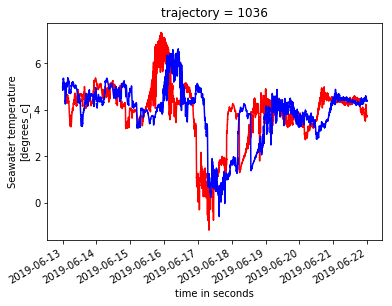

In [5]:
subset=ds.sel(time=slice('2019-06-13','2019-06-21'))
subset3=ds3.sel(time=slice('2019-06-13','2019-06-21'))
subset3.sea_water_temperature_00.plot(c='r')
subset.TEMP_SBE37_MEAN.plot(c='b')

# plot the data with an offset of 480 points

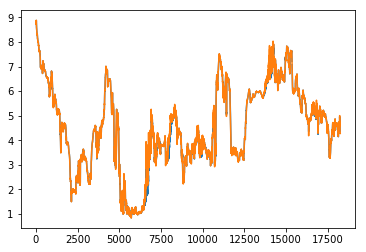

In [6]:
subset=ds.sel(time=slice('2019-06-01','2019-06-13'))
subset3=ds3.sel(time=slice('2019-06-01','2019-06-13'))
#subset3.sea_water_temperature_00.plot(c='r')
#subset.TEMP_SBE37_MEAN.plot(c='b')
plt.plot(subset.TEMP_SBE37_MEAN[480:])
plt.plot(subset3.sea_water_temperature_00[:-480])
#plt.plot(subset.TEMP_SBE37_MEAN[500:]-subset3.sea_water_temperature_00[:-500])

# check around 480 to find the minimum difference when moving timeseries around

In [9]:
subset=ds.sel(time=slice('2019-05-16','2019-10-10'))
subset3=ds3.sel(time=slice('2019-05-16','2019-10-10'))
for i in range(475,485):
    ts1=subset.TEMP_SBE37_MEAN[i:].data
    ts2=subset3.sea_water_temperature_01[:-i].data
    tdif=ts1-ts2
    print(i,np.nanmean(abs(tdif)),np.nanstd(abs(tdif)))
    #plt.plot(tdif)

475 0.05236232560950816 0.1116115573726983
476 0.046160214297488865 0.10364461761058394
477 0.039620921594162285 0.09503195875153869
478 0.03270624766468118 0.0866106044543354
479 0.02510730326891481 0.07736810853821231
480 0.016146739859110044 0.06772857037267424
481 0.018417870154133577 0.0663747057797739
482 0.025701044597327236 0.07499665125031617
483 0.03266858662622332 0.08464133562480966
484 0.039272691255179085 0.09350428520408993


# calculate offset in time (hours)

In [13]:
(((ds.time[480]-ds3.time[0])*1e-9)/60/60).data


array(8, dtype='timedelta64[ns]')

# check results, add 8 hours to SBE56 data and re-check difference

In [11]:
fname='saildrone-gen_5-arctic_misst_2019-sd1036-20190514T230000-20191011T183000-1_minutes-v1.1575336154680.nc'
ds=xr.open_dataset(data_dir+fname).isel(trajectory=0).swap_dims({'obs':'time'})
ds.close()
avehicle='1036'
fin=adir_sbe+'combined'+avehicle+'.nc'
ds2=xr.open_dataset(fin)
ds2['time']=ds2.time+np.timedelta64(8,'h')
ds3=ds2.interp(time=ds.time,method='nearest')

In [12]:
subset=ds.sel(time=slice('2019-05-16','2019-10-10'))
subset3=ds3.sel(time=slice('2019-05-16','2019-10-10'))
ts1=subset.TEMP_SBE37_MEAN.data
ts2=subset3.sea_water_temperature_01.data
tdif=ts1-ts2
print(np.nanmean(abs(tdif)),np.nanstd(abs(tdif)))


0.016130916444707506 0.0676416009711596


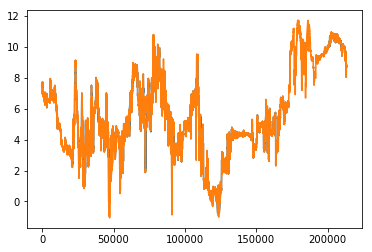

In [15]:
plt.plot(ts1)
plt.plot(ts2)